### This is a proof of concept for random forest

In [1]:
# load all packages

import numpy as np                      
import os                               # to work with filepaths and local directories
import matplotlib.pyplot as plt         # to display the output images in the notebook
%matplotlib inline

# Python image library (PIL) lets you access .tiff files
from PIL import Image

# to create and add functionality to a widget
import ipywidgets as widgets

# to display the widget
from IPython.display import display

# to save arrays to .tiff files
import imageio
# to check your OS in order to open a file saving prompt
import platform
import tempfile
import shutil
from tkinter import Tk, filedialog
from skimage import io, color

Load in any RGB images, ideally the ones matching the masked dataset later. 
Transform the 3 channels RGB into a grayscale mode. This is something that we should look into. We shall definitely use the RGB if possible.

<class 'numpy.ndarray'>
(695, 1152, 3)
<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=1152x695 at 0x1DB1783BD10>


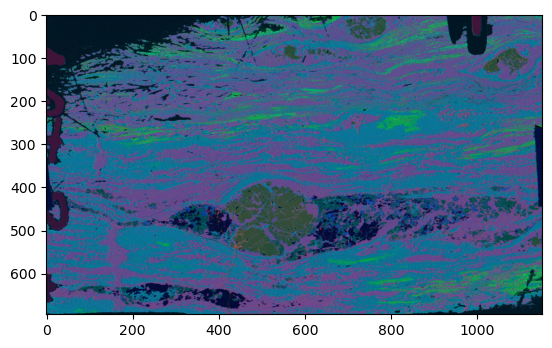

In [2]:
# Load in a single image
RGB_1 = Image.open('/Users/U/Documents/ESS469/Petro-Pixel-Poppers/ML-Geo-23/Aikin Data/78.7-10-1_Hot/RGB/78.7-10-1_Hot_MineralMasks-MgAlK.tif')

RGB_1_gray = color.rgb2gray(RGB_1)
# Turn this image into an array
RGB_1_array = np.asarray(RGB_1)
# RGB_1 = np.squeeze(RGB_1)

RGB_1_gray_array = np.asarray(RGB_1_gray)


print(type(RGB_1_array))
print(RGB_1_array.shape)
print(RGB_1)

plt.imshow(RGB_1)
# plt.show(RGB_1)

Load the mask(s). Ignore the commented codes. 

(695, 1152)


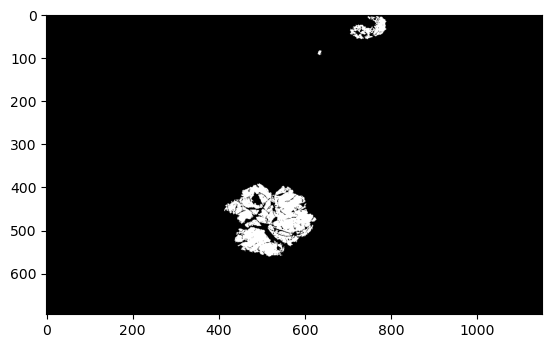

In [3]:
from skimage import io, color, filters
import matplotlib.pyplot as plt
from PIL import Image

# Load the grayscale image
grayscale_image_path = '/Users/U/Documents/ESS469/Petro-Pixel-Poppers/ML-Geo-23/Aikin Data/78.7-10-1_Hot/masks/78.7-10-1_Hot_mask-Garnet.tif'
grayscale_image = Image.open(grayscale_image_path)
# grayscale = io.imread(grayscale_image)
# grayscale_image = np.stack((grayscale_image,)*3, axis=-1)
grayscale_array = np.asarray(grayscale_image)

# # Convert the image to a valid data type (float or uint8)
# grayscale_image = grayscale_image.astype(np.float32)  # Adjust the data type if needed

# # Apply thresholding
# threshold_value = filters.threshold_otsu(grayscale_image)
# binary_image = (grayscale_image > threshold_value).astype(np.uint8)

# # Display the original and binary images
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# axes[0].imshow(grayscale_image, cmap='gray')
# axes[0].set_title('Original Grayscale Image')

# axes[1].imshow(binary_image, cmap='binary')
# axes[1].set_title('Binary Image')

print(grayscale_array.shape)
plt.imshow(grayscale_image, cmap = 'gray')

Now, flatten both images to make them a single array each.

In [4]:
RGB_1 = RGB_1_array.flatten()
RGB_1_gray = RGB_1_gray_array.flatten()
# binary_image = binary_image.flatten()
grayscale_image = grayscale_array.flatten()

print(RGB_1.shape)
# print(binary_image)
print(RGB_1_gray.shape)
print(grayscale_image.shape)

(2401920,)
(800640,)
(800640,)


Create a panda dataframe containing the RGB values and the corresponding mask values.

In [5]:
import pandas as pd

#Creating a pandas dataframe from all the arrays. T is used to transpose the dataframe
df = pd.DataFrame(data=[RGB_1_gray, grayscale_image]).T

#Assigning the column names to each feature
df.columns=['RGB','Mineral']

#Checking to see if it worked
print(df.head(5))
print(df['Mineral'].describe())

        RGB  Mineral
0  0.069927      1.0
1  0.078359      1.0
2  0.062635      1.0
3  0.096032      1.0
4  0.085629      1.0
count    800640.000000
mean          0.974803
std           0.156724
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Mineral, dtype: float64


Assign the new attributes into float for the RGB values and string for the mineral mask values.

In [6]:
#Assigning the correct data types to each feature
df.RGB=df['RGB'].astype(float)
df.Mineral=df['Mineral'].astype(str)

print(df.dtypes)

RGB        float64
Mineral     object
dtype: object


Please ignore the following cell. May be used some time later ?

In [27]:
# #Creating a subset dataframe where the area of interest value is known
# df_model=df[df['Mineral']!=('0.0')]

# #Checking our new data
# print(df_model.describe())

                 RGB
count  780466.000000
mean        0.326811
std         0.097687
min         0.008416
25%         0.319450
50%         0.351190
75%         0.380793
max         0.742318


Split the dataframe into 2. Reshape X into vetical(?) array to make sure the training/testing happens on 2D arrays.

In [7]:
X = np.array(df['RGB']).reshape(-1,1)
y = np.array(df['Mineral'])
print(X)
print(y)

[[0.06992745]
 [0.07835882]
 [0.0626349 ]
 ...
 [0.08734078]
 [0.0747051 ]
 [0.07579922]]
['1.0' '1.0' '1.0' ... '1.0' '1.0' '1.0']


Import relevant modules and scale the X features.

In [8]:
#Importing the train/test and scaling modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Splitting the data 75/25% into training and test data and then scaling the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

#Scaling our features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The most annoying and longest part of this process. Make sure to use a capable computer (set up to use 100% of your CPU power. Be prepared for any crashing if lots of Chrome tabs running in the background).
You can modify the decision trees (n_estimators) to your heart's content, but beware. If you don't have a $1000 CPU do not go over 200 trees (you can if you have lots of time to spare)

In [9]:
#Importing the random forest classifier and grid search module
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Creating our inital test classifier
RF = RandomForestClassifier()

#Selecting our algorithm variables that will be tested on our dataset and running them through a grid search
grid_param_RF = { 'n_estimators': [50, 100], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}
gd_sr_RF = GridSearchCV(estimator=RF, param_grid=grid_param_RF, scoring='accuracy',cv=10, n_jobs=-1)
gd_sr_RF.fit(X_train, y_train)

#Assigning a variable to the best paramaters and the classification accuracy
best_parameters_RF = gd_sr_RF.best_params_
best_result_RF = gd_sr_RF.best_score_

print(best_parameters_RF)
print(best_result_RF)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
0.9720140554223289


Use the best parameters from the previous cell (or use whatever you want) to create a new model. 

In [10]:
#Creating a new model with the desired parameters
model = RandomForestClassifier(bootstrap=True, criterion= 'entropy', n_estimators= 100)

#Fitting the model to the training data
model.fit(X_train, y_train)

#Printing all the model parameters
print(model)

RandomForestClassifier(criterion='entropy')


Split the initial dataframe to form an empty array containing the original grayscale values.

In [11]:
#Splitting the inital dataframe 
y_new = np.array(df.pop('Mineral').values)
X_new = np.array(df)

#Scaling it to match the model input
X_new = scaler.fit_transform(X_new)

Create numpy arrays of the prediction and probability data that satisfies whether the pixels are the mineral or not.

In [19]:
#Creating numpy arrays of the classification (prediction) data and the probablity that each value either satisfies 
#Garnet=1
y_pred = model.predict(X_new)
y_prob = model.predict_proba(X_new)

print(y_pred.shape, y_prob.shape)

(800640,) (800640, 2)


Find the MSE and R2 score of the predicted data.

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
print('The mean squared error:', mean_squared_error(y, y_pred))
print('The coefficient of determination:', r2_score(y, y_pred))

The mean squared error: 0.009016536770583533
The coefficient of determination: 0.6329135781703588


Since there are two possibilities (0 or 1), split the probability into 2 seperate 1D arrays.

In [13]:
#Splitting the y_prob array into two seperate 1 dimensional arrays
y_prob_split = np.split(y_prob, 2, axis=1)

y_prob_1 = y_prob_split[0]
y_prob_2 = y_prob_split[1]

print(y_prob_1.shape)

(800640, 1)


We are almost there. Reshape the 1D arrays into the original image size (695*1152). 

In [14]:
#Reshaping the 1d arrays to be representable as an image
y_pred = y_pred.reshape(695, 1152).astype(float)
y_prob_1 = y_prob_1.reshape(695, 1152)
y_prob_2 = y_prob_2.reshape(695, 1152)
# y_prob = y_prob.reshape(695, 1152)

For plotting, check whether probability 1 or 2 that conforms with predicted minerals. Sometimes, the inverse can happen. This is something that we need to fix later. Either way, one of them should show the reasonable mineral map.

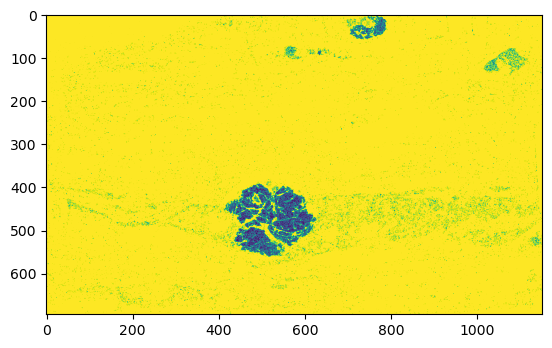

In [15]:
plt.imshow(y_prob_2)

In [ ]:
#Importing required packages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *

#Setting the image size
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

#Setting the eastings and northings boundary
bounds = [0, 1152, 0, 695]

#Loading the image data and setting extents
plt.title('Biotite Probability')
ax = plt.gca()
im = ax.imshow(y_prob_1, extent=bounds)

#Plotting colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

#Visualising the image
plt.show()

============================================================

The same procedure applies to the following blocks. Instead of grid search, we use random search here. There will be wider range of parameters compared to the previous approach. We can compare which one looks better. Or we can implement both in the future. The overall time should be similar.

In [84]:
import pandas as pd

#Creating a pandas dataframe from all the arrays. T is used to transpose the dataframe
df = pd.DataFrame(data=[RGB_1_gray, grayscale_image]).T

#Assigning the column names to each feature
df.columns=['RGB','Mineral']

#Checking to see if it worked
print(df.head(5))
print(df['Mineral'].describe())

        RGB  Mineral
0  0.069927      1.0
1  0.078359      1.0
2  0.062635      1.0
3  0.096032      1.0
4  0.085629      1.0
count    800640.000000
mean          0.802984
std           0.397745
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Mineral, dtype: float64


In [116]:
#Assigning the correct data types to each feature
df.RGB=df['RGB'].astype(float)
df.Mineral=df['Mineral'].astype(str)

print(df.dtypes)

RGB        float64
Mineral     object
dtype: object


In [117]:
X = np.array(df['RGB']).reshape(-1,1)
y = np.array(df['Mineral'])
print(X)
print(y)

[[0.06992745]
 [0.07835882]
 [0.0626349 ]
 ...
 [0.08734078]
 [0.0747051 ]
 [0.07579922]]
['1.0' '1.0' '1.0' ... '1.0' '1.0' '1.0']


In [118]:
# Using Random Search hyperparam

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from scipy.stats import randint

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False]
    
}

# Create an instance of the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Define the scoring metric as accuracy_score
scoring_metric = make_scorer(accuracy_score)

# Create an instance of RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_classifier,
    param_distributions=param_dist,
    n_iter=10,
    cv=10,
    scoring=scoring_metric,  # Use accuracy_score for scoring
    verbose=2,
    n_jobs=-1,
    random_state=42,
)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the RandomizedSearchCV object to your training data
random_search.fit(X_train, y_train)

# After fitting, you can access the best hyperparameters and the best estimator
print("Best hyperparameters:", random_search.best_params_)
print("Best estimator:", random_search.best_estimator_)

# Evaluate the best model on your test set
y_pred = random_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 13}
Best estimator: RandomForestClassifier(criterion='entropy', max_depth=17, min_samples_leaf=4,
                       min_samples_split=19, n_estimators=13)
Test Accuracy: 0.9745703437250199


In [119]:
model = RandomForestClassifier(criterion='entropy', max_depth=17, min_samples_leaf=4, min_samples_split=19, n_estimators=13, bootstrap = True)
#Fitting the model to the training data
model.fit(X_train, y_train)

#Printing all the model parameters
print(model)

RandomForestClassifier(criterion='entropy', max_depth=17, min_samples_leaf=4,
                       min_samples_split=19, n_estimators=13)


In [120]:
from sklearn.preprocessing import MinMaxScaler

#Scaling our features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [121]:
#Splitting the inital dataframe 
y_new = np.array(df.pop('Mineral').values)
X_new = np.array(df)

#Scaling it to match the model input
X_new = scaler.fit_transform(X_new)

In [122]:
#Creating numpy arrays of the classification (prediction) data and the probablity that each value either satisfies 
#Garnet=1
y_pred = model.predict(X_new)
y_prob = model.predict_proba(X_new)

print(y_pred.shape, y_prob.shape)

(800640,) (800640, 2)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('The mean squared error:', mean_squared_error(y, y_pred))
print('The coefficient of determination:', r2_score(y, y_pred))

In [123]:
#Splitting the y_prob array into two seperate 1 dimensional arrays
y_prob_split = np.split(y_prob, 2, axis=1)

y_prob_1 = y_prob_split[0]
y_prob_2 = y_prob_split[1]

print(y_prob_1.shape)

(800640, 1)


In [124]:
#Reshaping the 1d arrays to be representable as an image
y_pred = y_pred.reshape(695, 1152).astype(float)
y_prob_1 = y_prob_1.reshape(695, 1152)
y_prob_2 = y_prob_2.reshape(695, 1152)
# y_prob = y_prob.reshape(695, 1152)

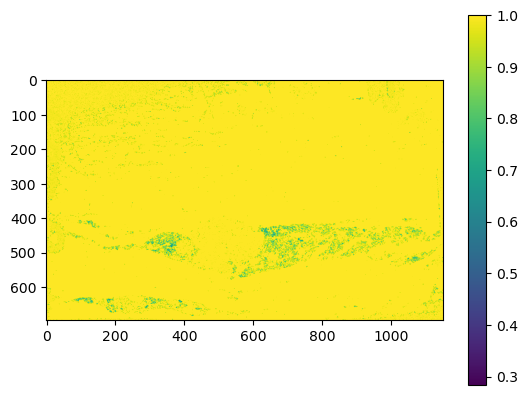

In [126]:
plt.imshow(y_prob_2)
plt.colorbar()

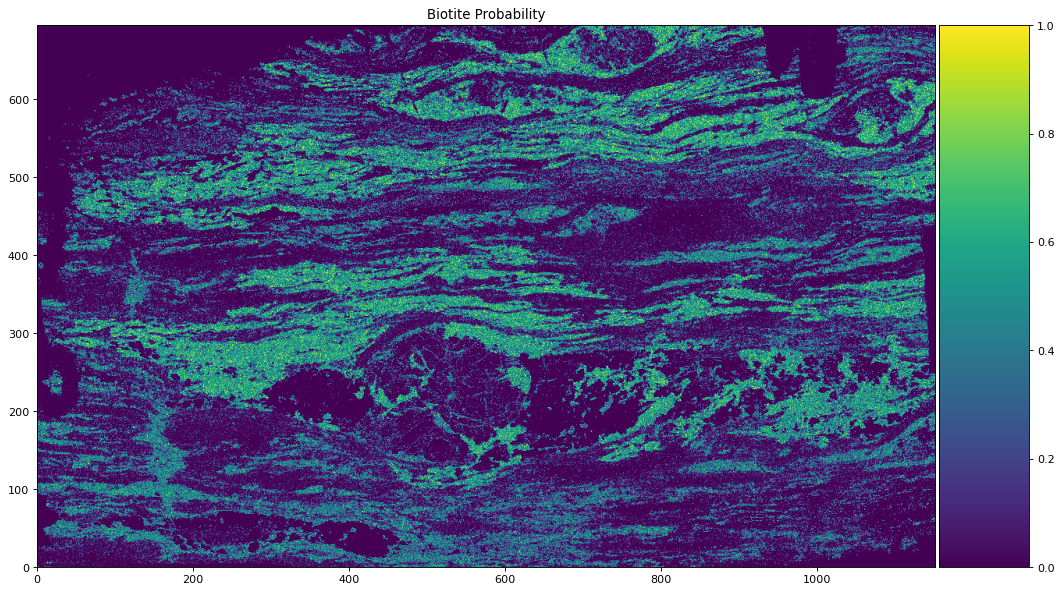

In [112]:
#Importing required packages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *

#Setting the image size
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

#Setting the eastings and northings boundary
bounds = [0, 1152, 0, 695]

#Loading the image data and setting extents
plt.title('Biotite Probability')
ax = plt.gca()
im = ax.imshow(y_prob_1, extent=bounds)

#Plotting colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

#Visualising the image
plt.show()

======================================================================================

Ignore the following parts. This is just a copy-paste code to see what works.

In [97]:
#Importing rasterio 
import rasterio as rio

#Accessing the metadata of the existing 'Geology' image
with rio.open('/Users/U/Documents/ESS469/Petro-Pixel-Poppers/ML-Geo-23/Aikin Data/78.7-10-2_Hot/78.7-10-2_Hot_FeKCa.Tiff') as src:
    study_area_ras = src.read()
    study_area_meta = src.profile

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1152, 'height': 695, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 695, 'tiled': False, 'interleave': 'band'}


C:\Users\U\AppData\Roaming\Python\Python311\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [104]:
#Viewing the transform and crs
study_area_transform = study_area_meta["transform"]
study_area_crs = study_area_meta["crs"]

print(study_area_transform)
print(study_area_crs)

| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
None


In [105]:
#Ensuring the count value is 1 (1 band of pixel data) and assigning the data as float to be compatible with the 
#new data
study_area_meta['count'] = 1
study_area_meta['dtype'] = "float64"

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1152, 'height': 695, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 695, 'tiled': False, 'interleave': 'band'}


In [106]:
print(study_area_meta(study_area_meta['count'] == 1))

TypeError: 'Profile' object is not callable

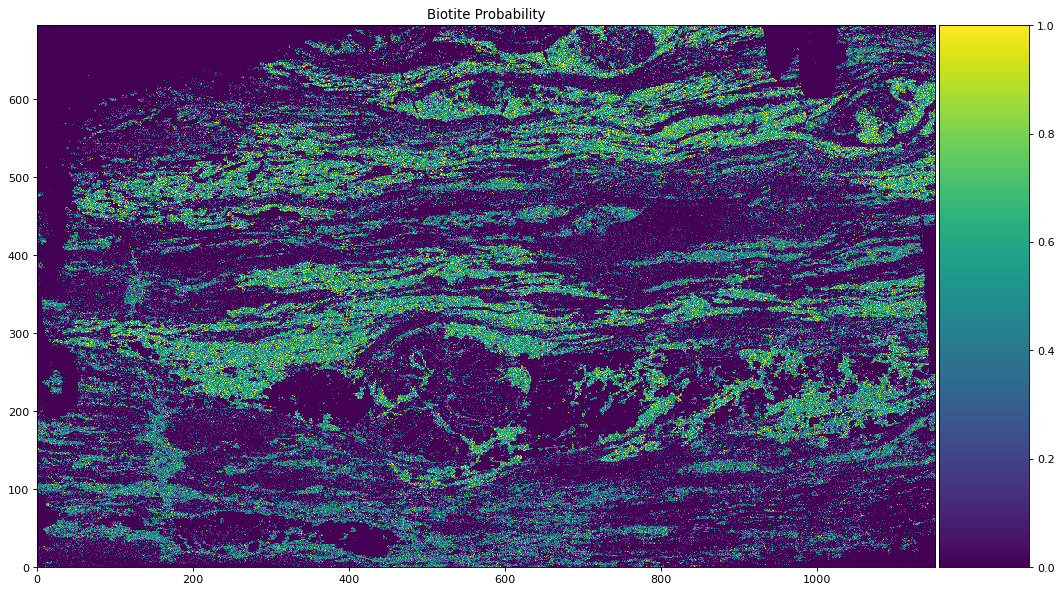

In [107]:
#Importing required packages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *

#Setting the image size
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

#Setting the eastings and northings boundary
bounds = [0, 1152, 0, 695]

#Loading the image data and setting extents
plt.title('Biotite Probability')
ax = plt.gca()
im = ax.imshow(y_prob_1, interpolation='nearest', extent=bounds)

#Plotting colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax)

#Visualising the image
plt.show()